#  <center> Speech Emotion Recognition <center>

In [ ]:
# pridedama prieiga prie google drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Masters_colabs/speech_emotion' #nuoroda į pagrindinį sistemos aplanką

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/Masters_colabs/speech_emotion #nuoroda į pagrindinį sistemos aplanką'
/content


In [ ]:
#nuoroda į pagrindinį sistemos aplanką
folder_path = '/content/drive/MyDrive/Masters_colabs/speech_emotion'

In [ ]:
# nuskaitomas kaggle API failas (atsisiunčiamas asmeninis kaggle api failas turi būti įdėtas prie įgyvendinamo kodo)
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! mkdir input
%cd input

In [ ]:
# # Atsisiunčiami duomenų rinkiniai iš Kaggle

# RAVDESS Emotional speech audio
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
! mkdir ravdess-emotional-speech-audio
! unzip ravdess-emotional-speech-audio -d ravdess-emotional-speech-audio

# CREMA-D Emotional speech audio
! kaggle datasets download -d ejlok1/cremad
! mkdir cremad
! unzip cremad -d cremad

# Toronto emotional speech set (TESS)
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
! mkdir toronto-emotional-speech-set-tess
! unzip toronto-emotional-speech-set-tess -d toronto-emotional-speech-set-tess

# Surrey Audio-Visual Expressed Emotion (SAVEE)
! kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
! mkdir surrey-audiovisual-expressed-emotion-savee
! unzip surrey-audiovisual-expressed-emotion-savee -d surrey-audiovisual-expressed-emotion-savee

In [ ]:
%cd folder_path

[Errno 2] No such file or directory: 'folder_path'
/content


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Embedding, LSTM
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [ ]:
# Paths for data.
Ravdess = folder_path + "/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/" 
Crema = folder_path + "/input/cremad/AudioWAV/"
Tess = folder_path + "/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = folder_path + "/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
1    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
2    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
3    angry  /content/drive/MyDrive/Masters_colabs/speech_e...
4    angry  /content/drive/MyDrive/Masters_colabs/speech_e...

## <center>2. Crema DataFrame</center>

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /content/drive/MyDrive/Masters_colabs/speech_e...
1    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
2      sad  /content/drive/MyDrive/Masters_colabs/speech_e...
3  neutral  /content/drive/MyDrive/Masters_colabs/speech_e...
4    angry  /content/drive/MyDrive/Masters_colabs/speech_e...

##  <center> 3. TESS dataset <center>

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /content/drive/MyDrive/Masters_colabs/speech_e...
1     fear  /content/drive/MyDrive/Masters_colabs/speech_e...
2     fear  /content/drive/MyDrive/Masters_colabs/speech_e...
3     fear  /content/drive/MyDrive/Masters_colabs/speech_e...
4     fear  /content/drive/MyDrive/Masters_colabs/speech_e...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  /content/drive/MyDrive/Masters_colabs/speech_e...
1    angry  /content/drive/MyDrive/Masters_colabs/speech_e...
2    angry  /content/drive/MyDrive/Masters_colabs/speech_e...
3    angry  /content/drive/MyDrive/Masters_colabs/speech_e...
4    angry  /content/drive/MyDrive/Masters_colabs/speech_e...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
1    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
2    happy  /content/drive/MyDrive/Masters_colabs/speech_e...
3    angry  /content/drive/MyDrive/Masters_colabs/speech_e...
4    angry  /content/drive/MyDrive/Masters_colabs/speech_e...

## Data Visualisation and Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


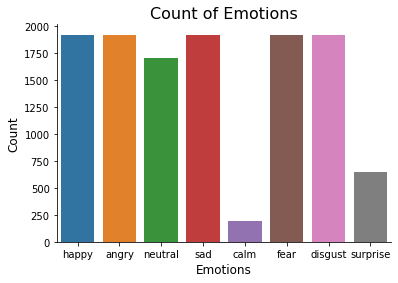

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

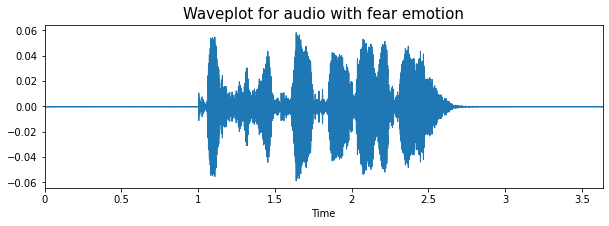

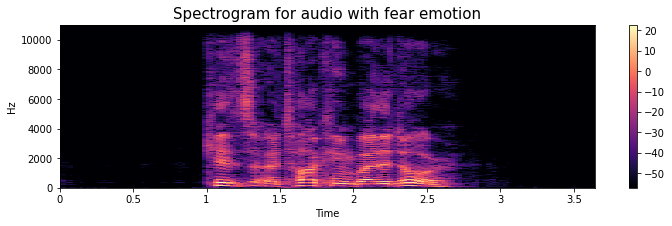

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

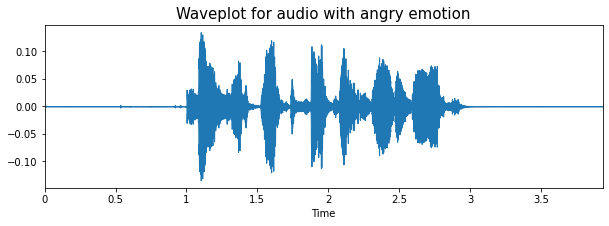

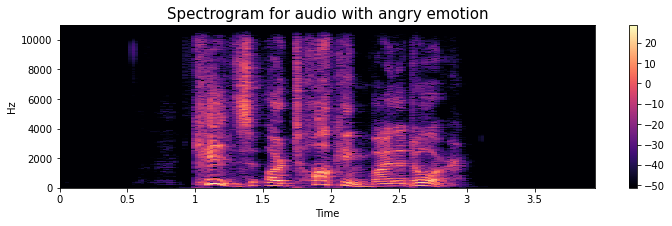

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

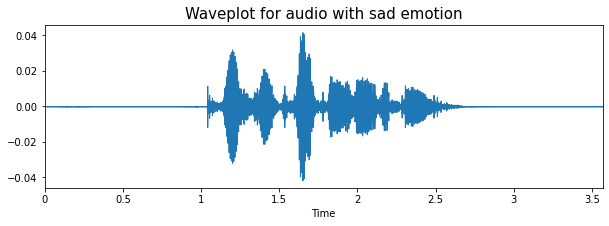

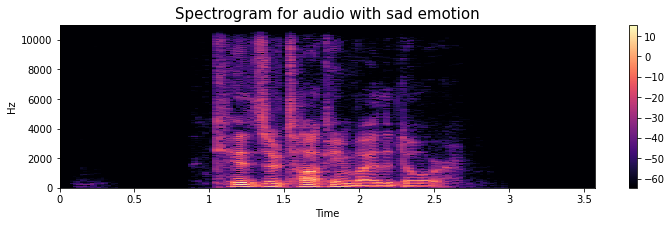

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

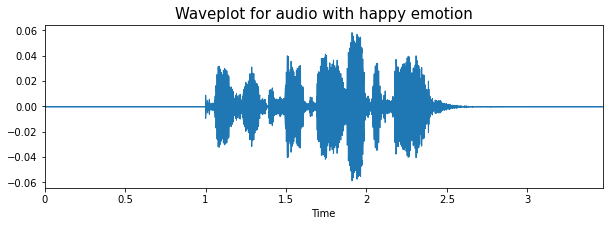

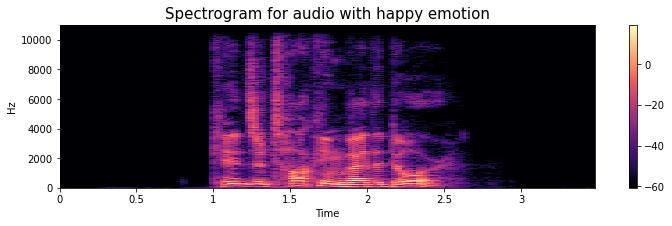

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]

#data, sample_rate = librosa.load(path) # orginali funkcija 
data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025) # koreguota funkcija (angl. downsampling)

#### 1. Simple Audio

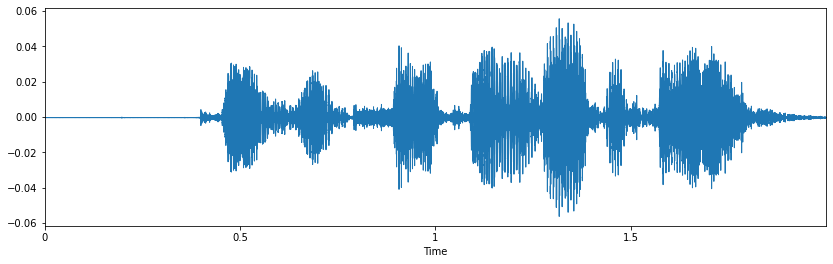

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

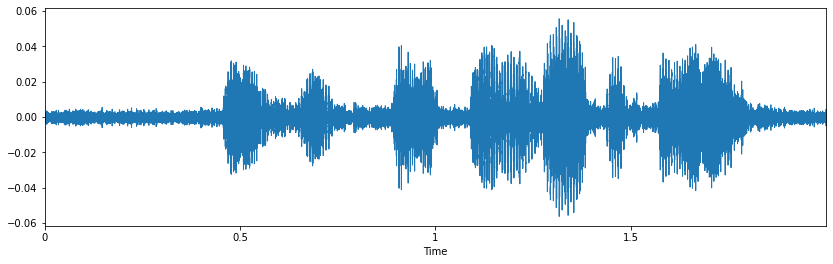

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

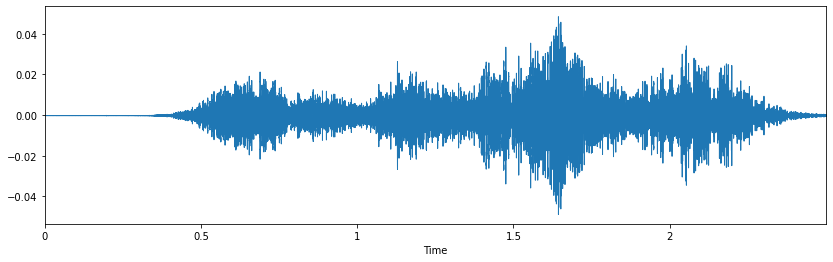

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

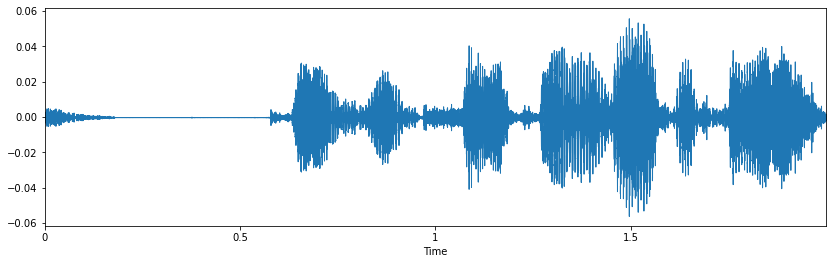

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

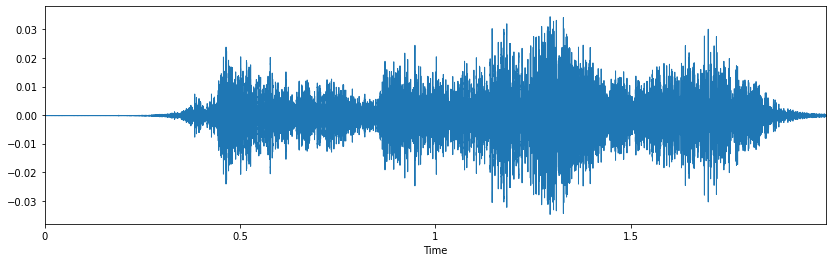

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

#Extracting features

In [ ]:
# įpatybių išgavimas trunka ilgą laiką

X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
 len(X), len(Y), data_path.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

# Data Preparation


In [ ]:
%cd '/content/drive/MyDrive/Masters_colabs/speech_emotion'

/content/drive/MyDrive/Masters_colabs/speech_emotion


In [ ]:
# nuskaitomi išsaugoti ypatybių duomenys
#Features =  pd.read_csv('saved_features2.csv')
Features =  pd.read_csv('features.csv')
print(Features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36486 entries, 0 to 36485
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 45.4+ MB
None


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

# First model

In [ ]:
def first_model(): # sudarytas pirminis Modelis
  model=Sequential()
  
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  
  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))
  
  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  
  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))
  
  model.add(Dense(units=8, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  return model

In [ ]:
# priskiriamas pirminis modelis prie model1
model1 = first_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

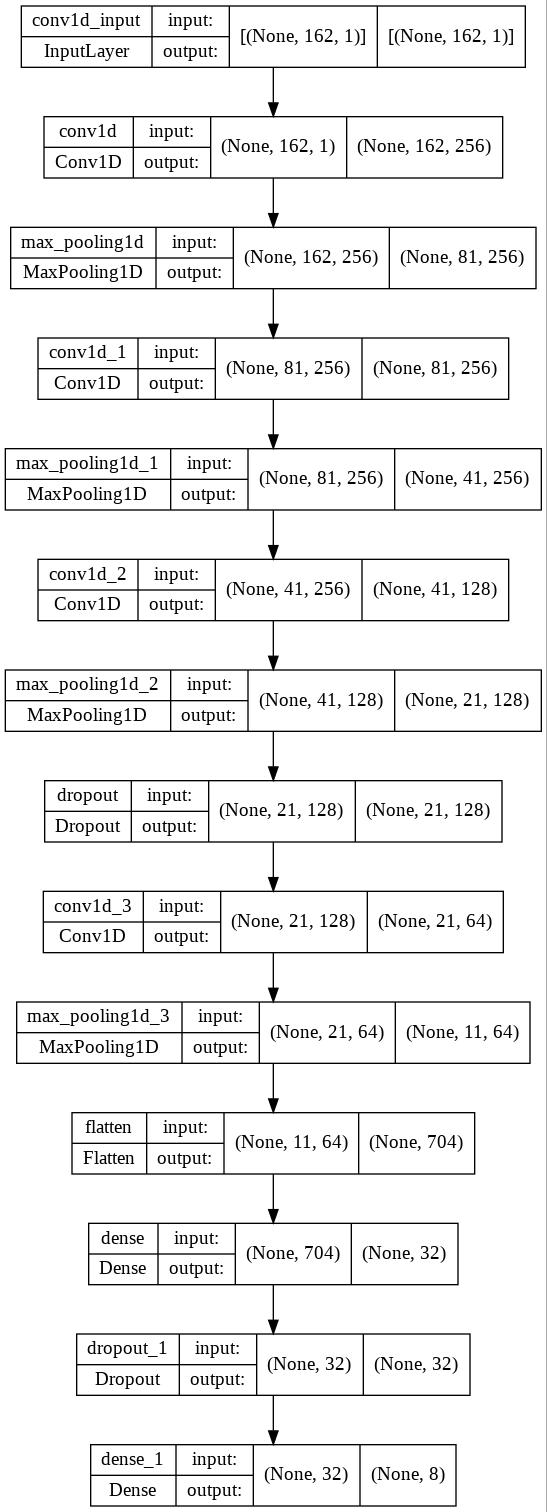

In [ ]:
# atvaizduojama galutinio modelio architektūra:
print(model1.summary())

tf.keras.utils.plot_model(model1, to_file="model1.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

# Second model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import activations

In [ ]:
def second_model(x_train, y_train): # sudarytas antrasis modelis
  model = Sequential()
  
  model.add(Conv1D(256, 8, padding='same', input_shape=(x_train.shape[1],1)))
  model.add(layers.Activation('relu'))

  model.add(Conv1D(256, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(layers.Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(layers.Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(layers.Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(layers.Activation('relu'))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(layers.Activation('relu'))

  model.add(Flatten())

  model.add(Dense(y_train.shape[1])) # Target class number
  model.add(layers.Activation('softmax'))

  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  return model

In [ ]:
# priskiriamas antrasis modelis prie model2
model2 = second_model(x_train, y_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          2304      
                                                                 
 activation (Activation)     (None, 162, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 162, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 162, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 162, 256)          0         
                                                                 
 dropout_2 (Dropout)         (None, 162, 256)          0         
                                                      

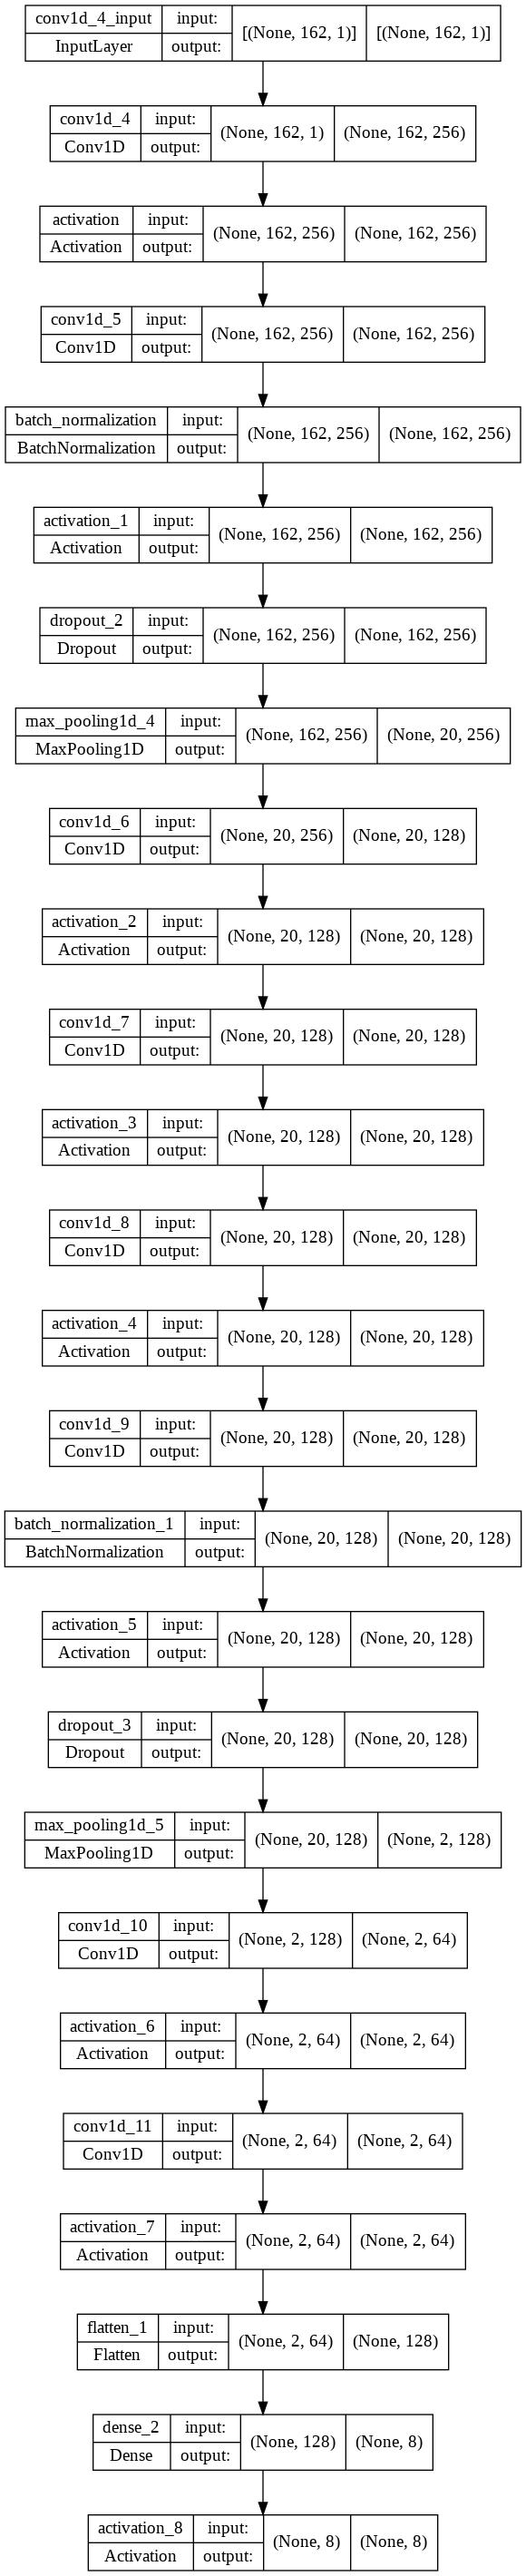

In [ ]:
# atvaizduojama antrojo modelio architektūra:
print(model2.summary())

tf.keras.utils.plot_model(model2, to_file="model2.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

# Third model

In [ ]:
from keras.layers import Bidirectional, CuDNNLSTM

In [ ]:
def third_model(): # sudaromas trečiasis LSTM modelis
  dropout = .1

  inputs = tf.keras.Input(shape=(x_train.shape[1],1))

  lstm1 = tf.keras.layers.Bidirectional(CuDNNLSTM(256, return_sequences=True))(inputs)
  drop1 = tf.keras.layers.Dropout(dropout)(lstm1)

  dense1 = tf.keras.layers.Dense(40)(drop1)
  elu1 = tf.keras.layers.ELU()(dense1)
  drop2 = tf.keras.layers.Dropout(dropout)(elu1)
  flat = tf.keras.layers.Flatten()(drop2)

  outputs = tf.keras.layers.Dense(8, activation='softmax')(flat) #sigmoid / softmax 
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer = 'adam',
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy'])
  return model

In [ ]:
# priskiriamas trečiasis modelis prie model3
model3 = third_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 162, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 162, 512)         530432    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 162, 512)          0         
                                                                 
 dense_3 (Dense)             (None, 162, 40)           20520     
                                                                 
 elu (ELU)                   (None, 162, 40)           0         
                                                                 
 dropout_5 (Dropout)         (None, 162, 40)           0         
                                                             

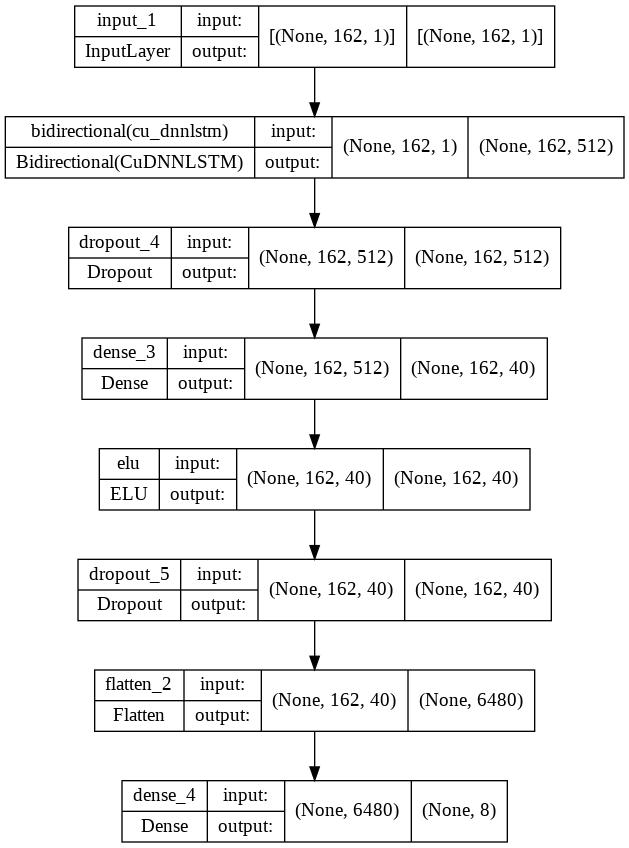

In [ ]:
# atvaizduojama trečiojo modelio architektūra:
print(model3.summary())

tf.keras.utils.plot_model(model3, to_file="model3.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

# Training function

In [ ]:
# nurodomi mokymo parametrai
epoch = 50
batches = 16
es_patience = 10

In [ ]:
def train_model(model,x_train, y_train,x_test,y_test, epoch, batches, es_patience, save_to): #------ custom training function


        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience, restore_best_weights=True)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        #rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
        
        history = model.fit(x_train,y_train,
                        batch_size=batches,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
                        #callbacks=[es,mc,lr_schedule,rlrp])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model,history

#training original model

In [ ]:
# apmokomas pirmasis modelis
%%time
model1,history = train_model(model1, x_train, y_train, x_test, y_test, epoch, batches, es_patience, save_to= './') 

Epoch 1/50
1705/1711 [============================>.] - ETA: 0s - loss: 1.2457 - accuracy: 0.5087
Epoch 1: val_accuracy improved from -inf to 0.53683, saving model to ./_best_model.h5
1711/1711 [==============================] - 10s 6ms/step - loss: 1.2453 - accuracy: 0.5089 - val_loss: 1.1523 - val_accuracy: 0.5368 - lr: 0.0010
Epoch 2/50
1708/1711 [============================>.] - ETA: 0s - loss: 1.1967 - accuracy: 0.5276
Epoch 2: val_accuracy improved from 0.53683 to 0.54758, saving model to ./_best_model.h5
1711/1711 [==============================] - 10s 6ms/step - loss: 1.1966 - accuracy: 0.5275 - val_loss: 1.1416 - val_accuracy: 0.5476 - lr: 9.0484e-04
Epoch 3/50
1705/1711 [============================>.] - ETA: 0s - loss: 1.1645 - accuracy: 0.5393
Epoch 3: val_accuracy improved from 0.54758 to 0.56347, saving model to ./_best_model.h5
1711/1711 [==============================] - 10s 6ms/step - loss: 1.1638 - accuracy: 0.5396 - val_loss: 1.1103 - val_accuracy: 0.5635 - lr: 8.18

#Evaluation of original model

In [ ]:
model_acc1 = model1.evaluate(x_test, y_test, verbose=0)[1]

In [ ]:
print("Accuracy of our model on test data: {:.3f}%".format(model_acc1 * 100))
#print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

Accuracy of our model on test data: 60.875%


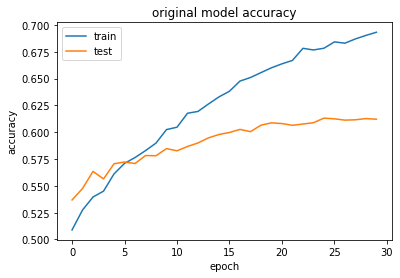

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('original model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

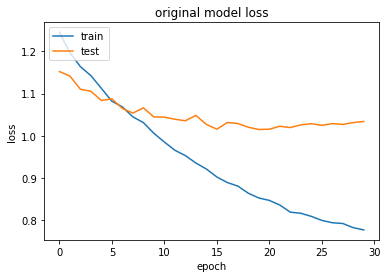

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('original model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predicting on test data.
pred_test = model1.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          disgust       disgust
2             fear          fear
3              sad           sad
4             fear          fear
5            happy         angry
6         surprise         happy
7            angry         angry
8          neutral       disgust
9          neutral           sad

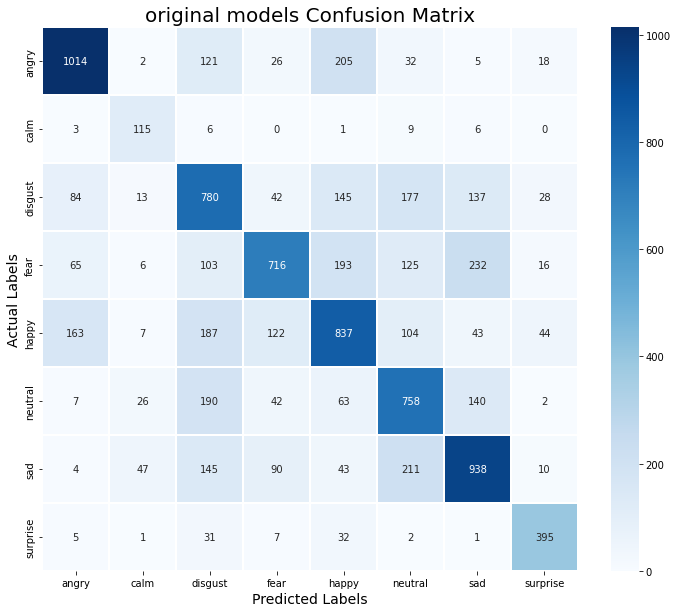

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('original models Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.71      0.73      1423
        calm       0.53      0.82      0.64       140
     disgust       0.50      0.55      0.53      1406
        fear       0.69      0.49      0.57      1456
       happy       0.55      0.56      0.55      1507
     neutral       0.53      0.62      0.57      1228
         sad       0.62      0.63      0.63      1488
    surprise       0.77      0.83      0.80       474

    accuracy                           0.61      9122
   macro avg       0.62      0.65      0.63      9122
weighted avg       0.62      0.61      0.61      9122



#training second model

In [ ]:
# iš naujo paruošiami naudojami duomenys
#Features =  pd.read_csv('saved_features2.csv')
Features =  pd.read_csv('features.csv')
print(Features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36486 entries, 0 to 36485
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 45.4+ MB
None


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [ ]:
# training second model
%%time
model2,history = train_model(model2, x_train, y_train, x_test, y_test, epoch, batches, es_patience, save_to= './') 

Epoch 1/50
1711/1711 [==============================] - ETA: 0s - loss: 1.4936 - accuracy: 0.4029
Epoch 1: val_accuracy improved from -inf to 0.46766, saving model to ./_best_model.h5
1711/1711 [==============================] - 20s 10ms/step - loss: 1.4936 - accuracy: 0.4029 - val_loss: 1.3172 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 2/50
1709/1711 [============================>.] - ETA: 0s - loss: 1.2338 - accuracy: 0.5106
Epoch 2: val_accuracy improved from 0.46766 to 0.50734, saving model to ./_best_model.h5
1711/1711 [==============================] - 18s 11ms/step - loss: 1.2337 - accuracy: 0.5106 - val_loss: 1.2576 - val_accuracy: 0.5073 - lr: 9.0484e-04
Epoch 3/50
1710/1711 [============================>.] - ETA: 0s - loss: 1.1441 - accuracy: 0.5431
Epoch 3: val_accuracy improved from 0.50734 to 0.51590, saving model to ./_best_model.h5
1711/1711 [==============================] - 18s 10ms/step - loss: 1.1441 - accuracy: 0.5431 - val_loss: 1.2484 - val_accuracy: 0.5159 - lr: 8

#Evaluation of third model

In [ ]:
model_acc2 = model2.evaluate(x_test, y_test, verbose=0)[1]

In [ ]:
print("Accuracy of second model on test data: {:.3f}%".format(model_acc2 * 100))

Accuracy of second model on test data: 64.942%


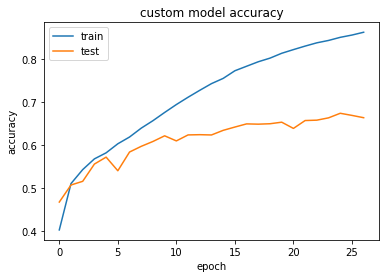

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('custom model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

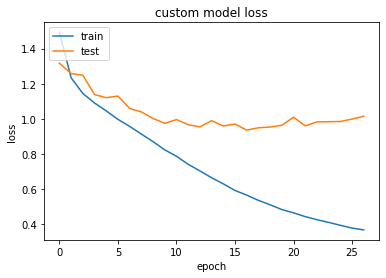

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('custom model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predicting on test data.
pred_test = model2.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          disgust       disgust
2             fear          fear
3              sad           sad
4            happy          fear
5          disgust         angry
6         surprise         happy
7            angry         angry
8          disgust       disgust
9          neutral           sad

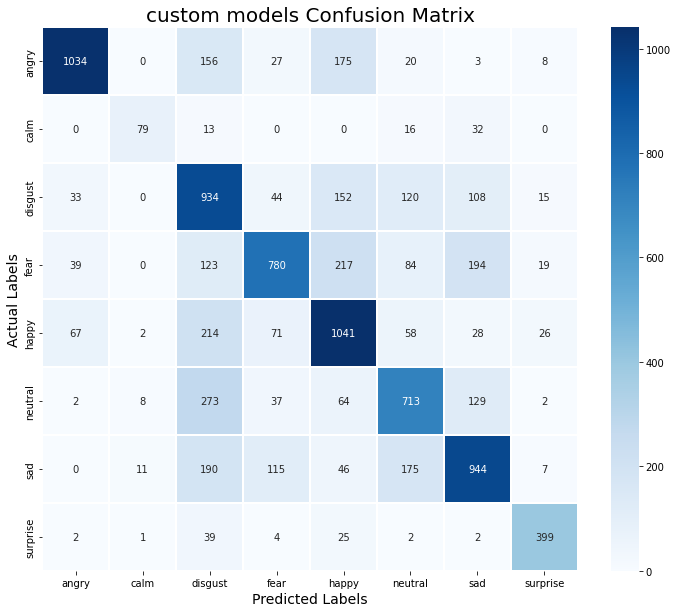

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('custom models Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.88      0.73      0.80      1423
        calm       0.78      0.56      0.66       140
     disgust       0.48      0.66      0.56      1406
        fear       0.72      0.54      0.62      1456
       happy       0.61      0.69      0.65      1507
     neutral       0.60      0.58      0.59      1228
         sad       0.66      0.63      0.64      1488
    surprise       0.84      0.84      0.84       474

    accuracy                           0.65      9122
   macro avg       0.70      0.65      0.67      9122
weighted avg       0.67      0.65      0.65      9122



#Training third model

In [ ]:
# iš naujo paruošiami naudojami duomenys
#Features =  pd.read_csv('saved_features2.csv')
Features =  pd.read_csv('features.csv')
print(Features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36486 entries, 0 to 36485
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 45.4+ MB
None


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [ ]:
#training third model
%%time
model3,history = train_model(model3, x_train, y_train, x_test, y_test, epoch, batches, es_patience, save_to= './') 

Epoch 1/50
1709/1711 [============================>.] - ETA: 0s - loss: 1.3831 - accuracy: 0.4692
Epoch 1: val_accuracy improved from -inf to 0.51557, saving model to ./_best_model.h5
1711/1711 [==============================] - 37s 20ms/step - loss: 1.3831 - accuracy: 0.4692 - val_loss: 1.2390 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/50
1709/1711 [============================>.] - ETA: 0s - loss: 1.2122 - accuracy: 0.5263
Epoch 2: val_accuracy improved from 0.51557 to 0.54845, saving model to ./_best_model.h5
1711/1711 [==============================] - 34s 20ms/step - loss: 1.2122 - accuracy: 0.5263 - val_loss: 1.1715 - val_accuracy: 0.5485 - lr: 9.0484e-04
Epoch 3/50
1709/1711 [============================>.] - ETA: 0s - loss: 1.1454 - accuracy: 0.5530
Epoch 3: val_accuracy improved from 0.54845 to 0.55733, saving model to ./_best_model.h5
1711/1711 [==============================] - 34s 20ms/step - loss: 1.1455 - accuracy: 0.5530 - val_loss: 1.1350 - val_accuracy: 0.5573 - lr: 8

#Evaluation of third model

In [ ]:
model_acc3 = model3.evaluate(x_test, y_test, verbose=0)[1]

In [ ]:
print("Accuracy of custom LSTM model on test data: {:.3f}%".format(model_acc3 * 100))

Accuracy of custom LSTM model on test data: 62.497%


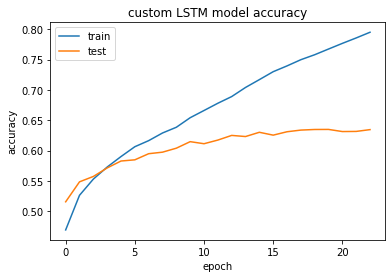

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('custom LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

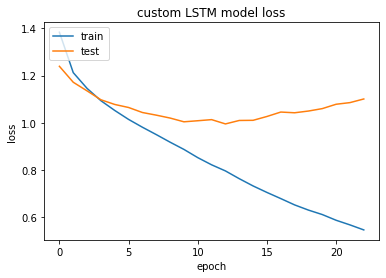

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('custom LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predicting on test data.
pred_test = model3.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          disgust       disgust
2             fear          fear
3              sad           sad
4             fear          fear
5            happy         angry
6            happy         happy
7            angry         angry
8          disgust       disgust
9              sad           sad

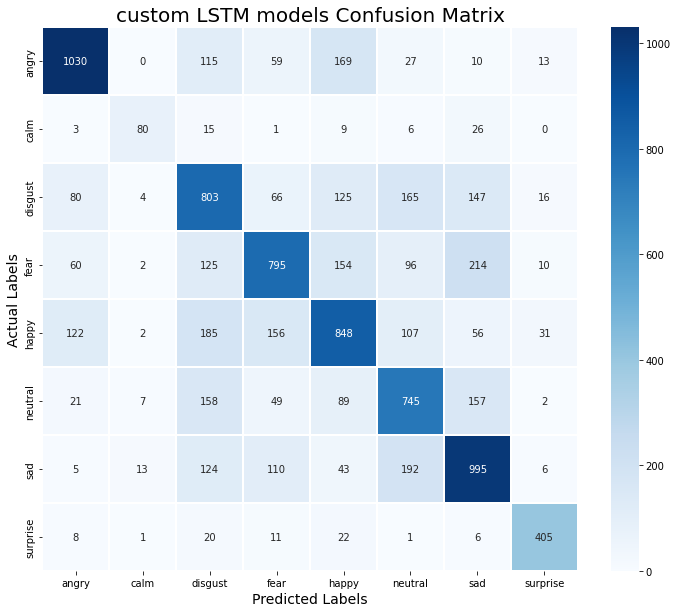

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('custom LSTM models Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.78      0.72      0.75      1423
        calm       0.73      0.57      0.64       140
     disgust       0.52      0.57      0.54      1406
        fear       0.64      0.55      0.59      1456
       happy       0.58      0.56      0.57      1507
     neutral       0.56      0.61      0.58      1228
         sad       0.62      0.67      0.64      1488
    surprise       0.84      0.85      0.85       474

    accuracy                           0.62      9122
   macro avg       0.66      0.64      0.65      9122
weighted avg       0.63      0.62      0.63      9122

